In [1]:
import torch
import os
from torch_geometric.data import Data, DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import sys

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score

In [2]:
import pickle
with open('three_layer_graph.pkl', 'rb') as f:
    loaded_object = pickle.load(f)

data_list = loaded_object

In [3]:
import pandas as pd
sub_id_list = pd.read_hdf('id_list.h5')
sub_id_list = list(sub_id_list[0])

/home/lizx43/anaconda3/envs/gigapath/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [4]:
image_id_res_df = pd.read_csv('../get_data/data_sheets/image_id_res.csv')

indications = list(image_id_res_df[image_id_res_df['images_id'].isin([int(x) for x in sub_id_list])].cancer)
responses = list(image_id_res_df[image_id_res_df['images_id'].isin([int(x) for x in sub_id_list])].ORR)
len(list(responses))

248

In [5]:
'''
ind = 0 
for data in data_list:
    ind += 1
    if(data[0]['edge_index'].shape[0]<2):
        print(ind, data[0]['edge_index'].shape[0], data[1]['edge_index'].shape[0], data[2]['edge_index'].shape[0])
'''

"\nind = 0 \nfor data in data_list:\n    ind += 1\n    if(data[0]['edge_index'].shape[0]<2):\n        print(ind, data[0]['edge_index'].shape[0], data[1]['edge_index'].shape[0], data[2]['edge_index'].shape[0])\n"

In [6]:
#Train with GPU
torch.cuda.empty_cache()
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:256'

In [7]:
all_labels = torch.cat([data[0].y for data in data_list]).long() 
class_counts = torch.bincount(all_labels)
class_weights = 1.0 / class_counts.float()
print("Class weights:", class_weights)

Class weights: tensor([0.0059, 0.0127])


In [8]:
sys.path.append('..')
from utils.train_utils import accuracy, save_model_pki
def train_gpu(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    total_acc = 0
    all_preds = []
    all_labels = []

    for data in train_loader:
        data_5x, data_10x, data_20x = data
        if data_5x.edge_index.shape[0] < 2:
            continue
        data_5x, data_10x, data_20x = data_5x.to(device), data_10x.to(device), data_20x.to(device)
        optimizer.zero_grad()
        output = model(data_5x, data_10x, data_20x)
        loss = criterion(output, data_5x.y.long())
        
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        acc = accuracy(output, data_5x.y.long())
        total_acc += acc.item()
        preds = torch.argmax(output, dim=1).cpu().numpy()
        labels = data_5x.y.cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels)

    average_loss = total_loss / len(train_loader)
    average_acc = total_acc / len(train_loader)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    auc = roc_auc_score(all_labels, all_preds)
    # return average_loss, average_acc, f1, auc
    return average_loss, average_acc, f1, auc, all_labels, all_preds

def valid_gpu(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    total_acc = 0
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for data in val_loader:
            data_5x, data_10x, data_20x = data
            if data_5x[0]['edge_index'].shape[0]<2:
                continue
            data_5x, data_10x, data_20x = data_5x.to(device), data_10x.to(device), data_20x.to(device)
            output = model(data_5x, data_10x, data_20x)
            loss = criterion(output, data_5x.y.long())
            acc = accuracy(output, data_5x.y.long())
            total_acc += acc.item()
            total_loss += loss.item()

            preds = torch.argmax(output, dim=1).cpu().numpy()
            probs = F.softmax(output, dim=1)[:, 1].cpu().numpy()  # Get the probability of the positive class

            labels = data_5x.y.cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels)
            all_probs.extend(probs)


    average_loss = total_loss / len(val_loader)
    average_acc = total_acc / len(val_loader)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    auc = roc_auc_score(all_labels, all_probs)

    # return average_loss, average_acc, f1, auc
    return average_loss, average_acc, f1, auc, all_labels, all_preds, all_probs


In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import seaborn as sns
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.matshow(cm_normalized, cmap='Blues')
    plt.colorbar(cax)

    for (i, j), val in np.ndenumerate(cm_normalized):
        plt.text(j, i, f'{val:.2%}', ha='center', va='center', color='red')

    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

def get_confusion_matrix_tn(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    return cm_normalized[1][1]

--Start Epoch 1/40--


/home/lizx43/anaconda3/envs/gigapath/lib/python3.9/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 1/40, Train Loss: 0.6762, Acc: 0.6616, F1: 0.6162, AUC: 0.5301
Epoch 1/40, Valid Loss: 0.6448, Acc: 0.6600, F1: 0.6427, AUC: 0.7255
0.35294117647058826
--Start Epoch 2/40--


/home/lizx43/anaconda3/envs/gigapath/lib/python3.9/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 2/40, Train Loss: 0.5420, Acc: 0.7172, F1: 0.6612, AUC: 0.5753
Epoch 2/40, Valid Loss: 0.5769, Acc: 0.6400, F1: 0.5455, AUC: 0.7415
0.058823529411764705
--Start Epoch 3/40--


/home/lizx43/anaconda3/envs/gigapath/lib/python3.9/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 3/40, Train Loss: 0.4339, Acc: 0.7980, F1: 0.7884, AUC: 0.7155
Epoch 3/40, Valid Loss: 0.5790, Acc: 0.7200, F1: 0.6801, AUC: 0.7219
0.29411764705882354
--Start Epoch 4/40--


/home/lizx43/anaconda3/envs/gigapath/lib/python3.9/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 4/40, Train Loss: 0.3407, Acc: 0.8586, F1: 0.8600, AUC: 0.8049
Epoch 4/40, Valid Loss: 0.5741, Acc: 0.7200, F1: 0.6801, AUC: 0.7415
0.29411764705882354
--Start Epoch 5/40--


/home/lizx43/anaconda3/envs/gigapath/lib/python3.9/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 5/40, Train Loss: 0.2143, Acc: 0.9394, F1: 0.9479, AUC: 0.9225
Epoch 5/40, Valid Loss: 0.6184, Acc: 0.6600, F1: 0.6689, AUC: 0.7522
0.7058823529411765
--Start Epoch 6/40--


/home/lizx43/anaconda3/envs/gigapath/lib/python3.9/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 6/40, Train Loss: 0.1456, Acc: 0.9646, F1: 0.9744, AUC: 0.9680
Epoch 6/40, Valid Loss: 0.7267, Acc: 0.6800, F1: 0.6344, AUC: 0.7504
0.23529411764705882
--Start Epoch 7/40--


/home/lizx43/anaconda3/envs/gigapath/lib/python3.9/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 7/40, Train Loss: 0.0650, Acc: 0.9848, F1: 0.9949, AUC: 0.9963
Epoch 7/40, Valid Loss: 0.6181, Acc: 0.6800, F1: 0.6481, AUC: 0.7718
0.29411764705882354
--Start Epoch 8/40--


/home/lizx43/anaconda3/envs/gigapath/lib/python3.9/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 8/40, Train Loss: 0.0258, Acc: 0.9899, F1: 1.0000, AUC: 1.0000
Epoch 8/40, Valid Loss: 0.7045, Acc: 0.6800, F1: 0.6481, AUC: 0.7718
0.29411764705882354
--Start Epoch 9/40--


/home/lizx43/anaconda3/envs/gigapath/lib/python3.9/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 9/40, Train Loss: 0.0132, Acc: 0.9899, F1: 1.0000, AUC: 1.0000
Epoch 9/40, Valid Loss: 0.7162, Acc: 0.6800, F1: 0.6481, AUC: 0.7790
0.29411764705882354
--Start Epoch 10/40--


/home/lizx43/anaconda3/envs/gigapath/lib/python3.9/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 10/40, Train Loss: 0.0094, Acc: 0.9899, F1: 1.0000, AUC: 1.0000
Epoch 10/40, Valid Loss: 0.7951, Acc: 0.6800, F1: 0.6481, AUC: 0.7665
0.29411764705882354
--Start Epoch 11/40--


/home/lizx43/anaconda3/envs/gigapath/lib/python3.9/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 11/40, Train Loss: 0.0082, Acc: 0.9899, F1: 1.0000, AUC: 1.0000
Epoch 11/40, Valid Loss: 0.7185, Acc: 0.7200, F1: 0.7017, AUC: 0.7665
0.4117647058823529
--Start Epoch 12/40--


/home/lizx43/anaconda3/envs/gigapath/lib/python3.9/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 12/40, Train Loss: 0.0069, Acc: 0.9899, F1: 1.0000, AUC: 1.0000
Epoch 12/40, Valid Loss: 0.8778, Acc: 0.6800, F1: 0.6481, AUC: 0.7576
0.29411764705882354
--Start Epoch 13/40--


/home/lizx43/anaconda3/envs/gigapath/lib/python3.9/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 13/40, Train Loss: 0.0066, Acc: 0.9899, F1: 1.0000, AUC: 1.0000
Epoch 13/40, Valid Loss: 0.8430, Acc: 0.6800, F1: 0.6481, AUC: 0.7415
0.29411764705882354
--Start Epoch 14/40--


/home/lizx43/anaconda3/envs/gigapath/lib/python3.9/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 14/40, Train Loss: 0.0049, Acc: 0.9899, F1: 1.0000, AUC: 1.0000
Epoch 14/40, Valid Loss: 0.9816, Acc: 0.6800, F1: 0.6344, AUC: 0.7433
0.23529411764705882
--Start Epoch 15/40--


/home/lizx43/anaconda3/envs/gigapath/lib/python3.9/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 15/40, Train Loss: 0.0049, Acc: 0.9899, F1: 1.0000, AUC: 1.0000
Epoch 15/40, Valid Loss: 0.7851, Acc: 0.7000, F1: 0.6977, AUC: 0.7504
0.5294117647058824


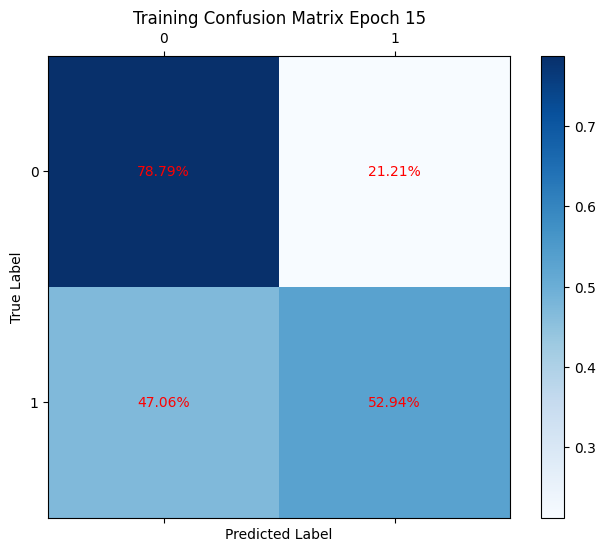

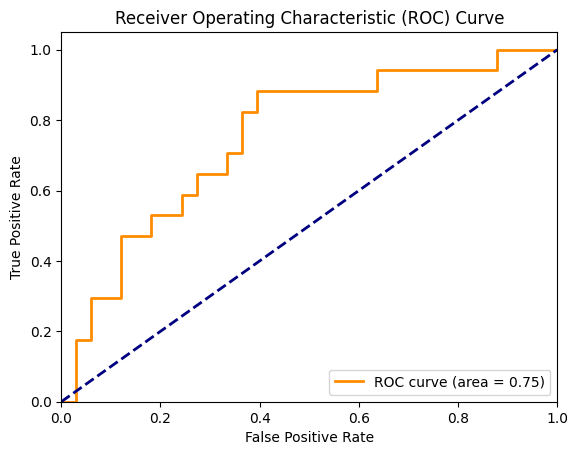

[0.5301153612629023, 0.5753491196114147, 0.7154826958105647, 0.8048573163327262, 0.9225258044930176, 0.9680024286581663, 0.9962962962962962, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] [0.7254901960784315, 0.7415329768270944, 0.7219251336898396, 0.7415329768270945, 0.7522281639928698, 0.750445632798574, 0.7718360071301248, 0.7718360071301248, 0.7789661319073085, 0.7664884135472371, 0.7664884135472371, 0.7575757575757576, 0.7415329768270945, 0.7433155080213903, 0.750445632798574]


In [39]:
# Instantiate your model
from GNN import MultiResolutionGraphModel
from torch import manual_seed
from torch_geometric.loader import DataLoader
from torch.utils.data import Subset

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_curve, auc


# Free up GPU memory
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()
# manual_seed(42)
# Instantiate your model
model = MultiResolutionGraphModel(num_features=1536, latent_dim=8, num_classes=2).to(device)
# Define the optimizer and criterion
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.001)  # Added weight decay
class_weights = class_weights.to(device)
# criterion = nn.CrossEntropyLoss(weight=class_weights, reduction='sum')
criterion = nn.CrossEntropyLoss(weight=class_weights)
train_loader = None
val_loader = None
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=4)
labels = np.array(responses)
indicators = np.array(indications)  # Assuming 'indicator' is an attribute
stratification_targets = np.array([f"{label}_{indicator}" for label, indicator in zip(labels, indicators)])

# for train_index, test_index in stratified_split.split(data_list, indicators):
for train_index, test_index in stratified_split.split(data_list, stratification_targets):
    train_loader = DataLoader(Subset(data_list, train_index), batch_size=1, shuffle=True)
    val_loader = DataLoader(Subset(data_list, test_index), batch_size=1, shuffle=False)

# train_dataset, val_dataset = train_test_split(data_list, test_size=0.2, random_state=42)
# train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
num_epochs = 40
train_auc_arr = []
val_auc_arr = []

for epoch in range(num_epochs):
    print(f'--Start Epoch {epoch+1}/{num_epochs}--')
    train_loss, train_acc, train_f1, train_auc, train_labels, train_preds = train_gpu(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc, val_f1, val_auc, val_labels, val_preds, val_probs = valid_gpu(model, val_loader, criterion, device) 
    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}, AUC: {train_auc:.4f}')
    print(f'Epoch {epoch + 1}/{num_epochs}, Valid Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}, AUC: {val_auc:.4f}')
    train_auc_arr.append(train_auc)
    val_auc_arr.append(val_auc)
    fpr, tpr, _ = roc_curve(val_labels, val_probs)
    roc_auc = auc(fpr, tpr)
    tn = get_confusion_matrix_tn(val_labels, val_preds)
    print(tn)
    if  train_auc>0.9 and train_loss<0.01 and val_auc>0.73 and epoch>10 and tn>0.5:
        plot_confusion_matrix(val_labels, val_preds, title=f'Training Confusion Matrix Epoch {epoch+1}')
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()
        # torch.save(model.state_dict(), 'save_model.pth')
        # break
print(train_auc_arr, val_auc_arr)

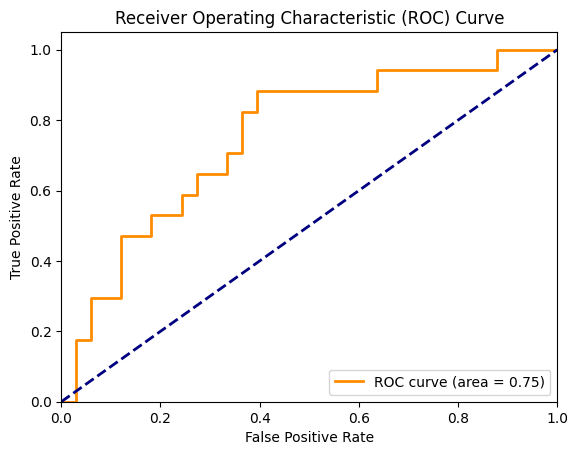

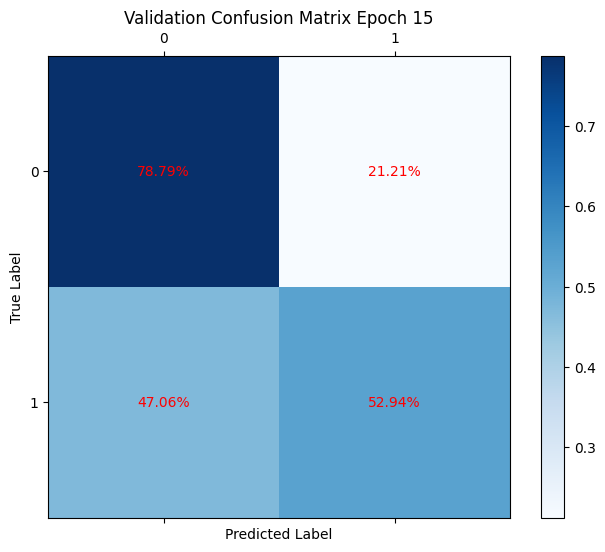

In [40]:
model.load_state_dict(torch.load('save_model.pth'))
val_loss, val_acc, val_f1, val_auc, val_labels, val_preds, val_probs = valid_gpu(model, val_loader, criterion, device) 
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
plot_confusion_matrix(val_labels, val_preds, title=f'Validation Confusion Matrix Epoch {epoch+1}')

In [ ]:
train_auc_arr_1=[0.5007046388725778, 0.5889019377568997, 0.7194362889019378, 0.7885496183206107, 0.8500880798590723, 0.953904873752202, 0.9577216676453318, 0.976923076923077, 0.9884908984145625, 1.0, 0.9846741045214328, 0.9923076923076923, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9577803875513798, 0.9657662947739284, 0.9731062830299472, 0.9961832061068702, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
val_auc_arr_1 = [0.6704781704781705, 0.7016632016632016, 0.7016632016632016, 0.6403326403326404, 0.6153846153846154, 0.6268191268191268, 0.5883575883575884, 0.7536382536382537, 0.7151767151767151, 0.7016632016632016, 0.6632016632016633, 0.7920997920997921, 0.7785862785862786, 0.6767151767151768, 0.7151767151767151, 0.7536382536382537, 0.7536382536382537, 0.7536382536382537, 0.7536382536382537, 0.7671517671517671, 0.6413721413721414, 0.6361746361746361, 0.7016632016632016, 0.6382536382536382, 0.7785862785862786, 0.7536382536382537, 0.7536382536382537, 0.7536382536382537, 0.7920997920997921, 0.7785862785862786, 0.7920997920997921, 0.7536382536382537, 0.7536382536382537, 0.7785862785862786, 0.7785862785862786, 0.7785862785862786, 0.7016632016632016, 0.7151767151767151, 0.7151767151767151, 0.7286902286902286]

train_auc_arr_2 = [0.4573643410852713, 0.53984268125855, 0.667920656634747, 0.80375056999544, 0.8734040127678978, 0.9330255357957136, 0.9628362973096215, 0.9887710898312814, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.887311901504788, 0.9361035111719106, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9701892384860921, 0.8652530779753762, 0.9516073871409029, 1.0, 1.0] 
val_auc_arr_2 = [0.5, 0.48717948717948717, 0.6089743589743589, 0.5115384615384616, 0.5858974358974359, 0.7192307692307692, 0.6230769230769231, 0.7205128205128205, 0.6846153846153846, 0.6102564102564102, 0.6230769230769231, 0.6230769230769231, 0.6602564102564102, 0.6230769230769231, 0.6230769230769231, 0.673076923076923, 0.6230769230769231, 0.5858974358974359, 0.7730769230769231, 0.7730769230769231, 0.7730769230769231, 0.7602564102564102, 0.7474358974358974, 0.7602564102564102, 0.7602564102564102, 0.7602564102564102, 0.7474358974358974, 0.7602564102564102, 0.7474358974358974, 0.7602564102564102, 0.7730769230769231, 0.7474358974358974, 0.7602564102564102, 0.7730769230769231, 0.7474358974358974, 0.6076923076923078, 0.7346153846153846, 0.6717948717948717, 0.6974358974358975, 0.7102564102564103]

train_auc_arr_3 = [0.5092777451556078, 0.5, 0.5, 0.5, 0.5309453904873752, 0.6269524368761009, 0.6463887257780387, 0.731238990017616, 0.8809160305343512, 0.950029359953024, 0.9884908984145625, 0.9846153846153847, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.976981796829125, 0.9578978273634762, 0.9462712859659425, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] 
val_auc_arr_3 = [0.5, 0.5, 0.5, 0.5, 0.5883575883575884, 0.5634095634095635, 0.7016632016632016, 0.6517671517671517, 0.604989604989605, 0.6361746361746361, 0.5883575883575884, 0.656964656964657, 0.5841995841995842, 0.6091476091476091, 0.6226611226611227, 0.5977130977130977, 0.6112266112266111, 0.6091476091476091, 0.6361746361746361, 0.5977130977130977, 0.5977130977130977, 0.5997920997920998, 0.5, 0.6226611226611227, 0.5841995841995842, 0.5956340956340956, 0.6226611226611227, 0.6496881496881497, 0.6496881496881497, 0.6496881496881497, 0.6205821205821205, 0.6496881496881497, 0.6496881496881497, 0.6496881496881497, 0.6496881496881497, 0.6496881496881497, 0.6112266112266111, 0.6496881496881497, 0.6112266112266111, 0.6496881496881497]

train_auc_arr_4 =  [0.5, 0.5, 0.5, 0.5, 0.5333333333333333, 0.5666666666666667, 0.7619047619047619, 0.6952380952380952, 0.6952380952380952, 0.6857142857142856, 0.6761904761904761, 0.6761904761904761, 0.6666666666666666, 0.6476190476190476, 0.6333333333333334, 0.6761904761904761, 0.6333333333333334, 0.661904761904762, 0.6476190476190476, 0.6476190476190476, 0.6047619047619048, 0.6619047619047619, 0.7380952380952381, 0.7142857142857142, 0.7142857142857142, 0.7142857142857142, 0.7000000000000002, 0.7000000000000002, 0.7000000000000002, 0.6857142857142857, 0.6809523809523809, 0.7000000000000002, 0.6809523809523809, 0.7142857142857142, 0.7000000000000002, 0.6857142857142857, 0.7000000000000002, 0.7047619047619048, 0.6809523809523809, 0.6952380952380952]
val_auc_arr_4 = [0.49749373433583965, 0.5, 0.5, 0.49624060150375937, 0.6553884711779449, 0.8663324979114453, 0.9331662489557226, 0.984544695071011, 0.9883040935672515, 0.9962406015037594, 0.9962406015037594, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9920634920634921, 0.8826232247284879, 0.9532163742690059, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

train_auc_arr_5 = [0.49615384615384617, 0.5553960964408726, 0.707577497129736, 0.8242824339839265, 0.9172215843857634, 0.9549942594718716, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8312858783008036, 0.9285304247990815, 0.9961538461538462, 0.9925373134328358, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8719862227324914]
val_auc_arr_5 =[0.5, 0.5191387559808612, 0.5191387559808612, 0.6997607655502392, 0.6100478468899522, 0.6291866028708134, 0.5837320574162679, 0.6351674641148325, 0.5837320574162679, 0.6028708133971292, 0.5897129186602871, 0.6351674641148325, 0.6028708133971292, 0.5574162679425836, 0.6806220095693779, 0.6806220095693779, 0.7392344497607655, 0.4796650717703349, 0.7320574162679427, 0.576555023923445, 0.6674641148325359, 0.6543062200956937, 0.6674641148325359, 0.6411483253588517, 0.6866028708133971, 0.6866028708133971, 0.6866028708133971, 0.6543062200956937, 0.6866028708133971, 0.6866028708133971, 0.6088516746411483, 0.6866028708133971, 0.6997607655502392, 0.7320574162679427, 0.6351674641148325, 0.6220095693779905, 0.6220095693779905, 0.6866028708133971, 0.5897129186602871, 0.6602870813397128]


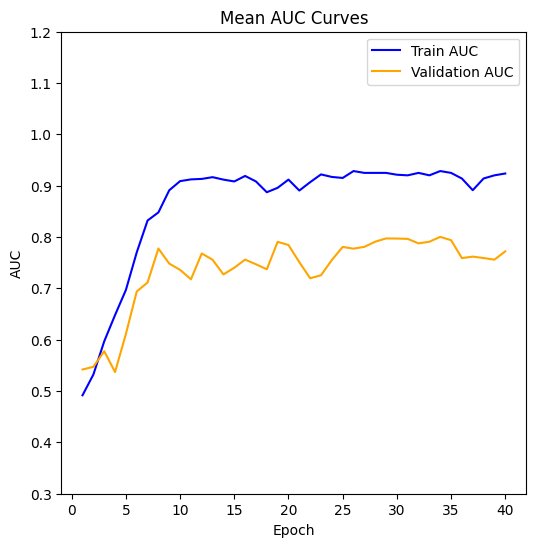

In [ ]:
def calculate_mean_std(auc_all, num_epochs):
    auc_all = np.array(auc_all)
    mean_auc = np.mean(auc_all, axis=0)
    std_auc = np.std(auc_all, axis=0)
    return mean_auc, std_auc

# train_auc_all=[train_auc_arr_1, train_auc_arr_2, train_auc_arr_3]
# val_auc_all=[val_auc_arr_1, val_auc_arr_2, val_auc_arr_3]
train_auc_all=[train_auc_arr_1,train_auc_arr_2, train_auc_arr_3, train_auc_arr_4]
val_auc_all=[val_auc_arr_1, val_auc_arr_2, val_auc_arr_3, val_auc_arr_4]

mean_train_auc, std_train_auc = calculate_mean_std(train_auc_all, 40)
mean_val_auc, std_val_auc = calculate_mean_std(val_auc_all, 40)

# def plot_mean_auc_curves(mean_train_auc, std_train_auc, mean_val_auc, std_val_auc, num_epochs):
def plot_mean_auc_curves(mean_train_auc, mean_val_auc, num_epochs):

    epochs = np.arange(1, num_epochs + 1)
    
    plt.figure(figsize=(6, 6))

    # Plot mean AUC for training with standard deviation
    plt.plot(epochs, mean_train_auc, label='Train AUC', color='blue')
    # plt.fill_between(epochs, mean_train_auc - std_train_auc, mean_train_auc + std_train_auc, color='blue', alpha=0.2)

    # Plot mean AUC for validation with standard deviation
    plt.plot(epochs, mean_val_auc, label='Validation AUC', color='orange')
    # plt.fill_between(epochs, mean_val_auc - std_val_auc, mean_val_auc + std_val_auc, color='orange', alpha=0.2)
    plt.ylim(0.3, 1.2)

    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.title('Mean AUC Curves')
    plt.legend()
    plt.show()

# Plot the mean AUC curves
plot_mean_auc_curves(mean_train_auc, mean_val_auc, 40)


In [ ]:
from sklearn.model_selection import KFold
from torch.utils.data import Subset
from GNN import MultiResolutionGraphModel
from sklearn.model_selection import StratifiedKFold

def cross_validation_and_sensitivity_analysis(dataset, num_features, latent_dim, num_classes, num_folds=5, num_epochs=50, learning_rates=[0.001], weight_decays=[1e-5]):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    torch.cuda.empty_cache()
    # kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    labels = np.array(responses)
    indicators = np.array(indications)  # Assuming 'indicator' is an attribute
    
    stratification_targets = np.array([f"{label}_{indicator}" for label, indicator in zip(labels, indicators)])
    # stratification_targets=indicators
    # manual_seed(42)
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=623)
    results = []
    train_auc_all = []
    val_auc_all = []
    for lr in learning_rates:
        for wd in weight_decays:
            fold_results = []
            fold_train_auc = []
            fold_val_auc = []
            # for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
            for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(stratification_targets)), stratification_targets)):
                train_subset = Subset(dataset, train_idx)
                val_subset = Subset(dataset, val_idx)
                train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
                val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)

                model = MultiResolutionGraphModel(num_features=num_features, latent_dim=latent_dim, num_classes=num_classes).to(device)

                # Compute class weights for the current fold
                all_labels = torch.cat([data[0].y for data in train_loader.dataset]).long()
                class_counts = torch.bincount(all_labels)
                class_weights = (1.0 / class_counts.float()).to(device)
                criterion = nn.CrossEntropyLoss(weight=class_weights)
                optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
                single_fold_res = []
                single_fold_train_auc = []
                single_fold_val_auc = []
                print('----Fold', fold, lr, wd)

                for epoch in range(num_epochs):
                    train_loss, train_acc, train_f1, train_auc, train_labels, train_preds  = train_gpu(model, train_loader, optimizer, criterion, device)
                    val_loss, val_acc, val_f1, val_auc, val_labels, val_preds, val_probs = valid_gpu(model, val_loader, criterion, device)
                    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}, AUC: {train_auc:.4f}')
                    print(f'Epoch {epoch + 1}/{num_epochs}, Valid Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}, AUC: {val_auc:.4f}')
                    single_fold_res.append((train_loss, train_acc, train_f1, train_auc, val_loss, val_acc, val_f1, val_auc))
                    single_fold_train_auc.append(train_auc)
                    single_fold_val_auc.append(val_auc)
                    fold_results.append((train_loss, train_acc, train_f1, train_auc, val_loss, val_acc, val_f1, val_auc))
                fold_train_auc.append(single_fold_train_auc)
                fold_val_auc.append(single_fold_val_auc)
            train_auc_all.append(fold_train_auc)
            val_auc_all.append(fold_val_auc)
            print(fold_train_auc)
            print(fold_val_auc)

            avg_fold_results = np.mean(fold_results, axis=0)

            results.append((lr, wd, avg_fold_results))
    return results


In [ ]:
dataset = data_list 
num_features = 1536
latent_dim = 8
num_classes = 2
# learning_rates = [0.001, 0.0001]
# weight_decays = [1e-3, 1e-4]
learning_rates=[1e-4]
weight_decays=[1e-3]
num_folds = 5
num_epochs = 40

results = cross_validation_and_sensitivity_analysis(dataset, num_features, latent_dim, num_classes, num_folds, num_epochs, learning_rates, weight_decays)
# results, train_auc_all, val_auc_all = cross_validation_and_sensitivity_analysis(dataset, num_features, latent_dim, num_classes)
# for lr, wd, metrics in results:
#     print(f"LR: {lr}, WD: {wd}, Metrics: {metrics}")

----Fold 0 0.0001 0.001


/home/lizx43/anaconda3/envs/gigapath/lib/python3.9/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 1/40, Train Loss: 0.6283, Acc: 0.6869, F1: 0.5685, AUC: 0.5000
Epoch 1/40, Valid Loss: 0.6497, Acc: 0.6400, F1: 0.4995, AUC: 0.6840


/home/lizx43/anaconda3/envs/gigapath/lib/python3.9/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 2/40, Train Loss: 0.6046, Acc: 0.6869, F1: 0.5685, AUC: 0.5000
Epoch 2/40, Valid Loss: 0.6578, Acc: 0.6400, F1: 0.4995, AUC: 0.6997


/home/lizx43/anaconda3/envs/gigapath/lib/python3.9/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 3/40, Train Loss: 0.5981, Acc: 0.6869, F1: 0.5685, AUC: 0.5000
Epoch 3/40, Valid Loss: 0.6383, Acc: 0.6400, F1: 0.4995, AUC: 0.6875


/home/lizx43/anaconda3/envs/gigapath/lib/python3.9/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


KeyboardInterrupt: 

: 

In [ ]:
import torch
import numpy as np
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Subset, DataLoader
from GNN import MultiResolutionGraphModel
from torch import nn

def nested_cross_validation(dataset, num_features, latent_dim, num_classes, num_outer_folds=5, num_inner_folds=5, num_epochs=50, learning_rate=0.001, weight_decay=1e-5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    torch.cuda.empty_cache()
    
    labels = np.array(responses)
    indicators = np.array(indications)  # Assuming 'indicator' is an attribute
    stratification_targets = indicators
    outer_skf = StratifiedKFold(n_splits=num_outer_folds, shuffle=True, random_state=4)
    results = []

    for fold_outer, (train_val_idx, test_idx) in enumerate(outer_skf.split(np.zeros(len(stratification_targets)), stratification_targets)):
        print('---', fold_outer)
        train_val_subset = Subset(dataset, train_val_idx)
        test_subset = Subset(dataset, test_idx)
        train_val_loader = DataLoader(train_val_subset, batch_size=1, shuffle=True)
        test_loader = DataLoader(test_subset, batch_size=1, shuffle=False)

        inner_skf = StratifiedKFold(n_splits=num_inner_folds, shuffle=True, random_state=4)
        best_model = None
        best_val_score = float('-inf')
        
        for fold_inner, (train_idx, val_idx) in enumerate(inner_skf.split(np.zeros(len(train_val_idx)), stratification_targets[train_val_idx])):
            print('---', fold_outer, fold_inner)
            inner_train_subset = Subset(train_val_subset, train_idx)
            inner_val_subset = Subset(train_val_subset, val_idx)
            inner_train_loader = DataLoader(inner_train_subset, batch_size=1, shuffle=True)
            inner_val_loader = DataLoader(inner_val_subset, batch_size=1, shuffle=False)

            model = MultiResolutionGraphModel(num_features=num_features, latent_dim=latent_dim, num_classes=num_classes).to(device)

            all_labels = torch.cat([data[0].y for data in inner_train_loader.dataset]).long()
            class_counts = torch.bincount(all_labels)
            class_weights = (1.0 / class_counts.float()).to(device)
            criterion = nn.CrossEntropyLoss(weight=class_weights)
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
            
            single_inner_fold_res = []
            for epoch in range(num_epochs):
                train_loss, train_acc, train_f1, train_auc = train_gpu(model, inner_train_loader, optimizer, criterion, device)
                val_loss, val_acc, val_f1, val_auc = valid_gpu(model, inner_val_loader, criterion, device)
                single_inner_fold_res.append((train_loss, train_acc, train_f1, train_auc, val_loss, val_acc, val_f1, val_auc))
            
            avg_inner_fold_results = np.mean(single_inner_fold_res, axis=0)
            val_score = avg_inner_fold_results[5]  # Assuming validation accuracy is the 6th element

            if val_score > best_val_score:
                best_val_score = val_score
                best_model = model.state_dict()  # Save the best model state
        
        # Load the best model for the outer loop
        model.load_state_dict(best_model)
        
        single_outer_fold_res = []
        for epoch in range(num_epochs):
            train_loss, train_acc, train_f1, train_auc = train_gpu(model, train_val_loader, optimizer, criterion, device)
            test_loss, test_acc, test_f1, test_auc = valid_gpu(model, test_loader, criterion, device)
            single_outer_fold_res.append((train_loss, train_acc, train_f1, train_auc, test_loss, test_acc, test_f1, test_auc))
        
        results.append(single_outer_fold_res)
    
    return results
